# RNN Model Development

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Masking
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from datetime import datetime, timedelta


In [35]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Importing Dogecoin data (hrly)

In [36]:
now = datetime.now()

def hour_rounder(t):
    # Rounds to nearest hour by adding a timedelta hour if minute >= 30
    return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
               +timedelta(hours=t.minute//30))

In [37]:
df=pd.read_csv('/content/gdrive/MyDrive/dogecoin_history_1h_2021-08-28T00_00_00Z---2021-11-26T00_00_00Z.csv')
df.rename(columns= {"Unnamed: 0": "Date"}, inplace= True)
df["datetime"] = pd.to_datetime(df["datetime"], infer_datetime_format= True)
df["datetime"] = df.datetime.apply(lambda x: hour_rounder(x))
df = df.set_index("datetime")
df.interpolate(method= "linear", inplace= True)
df.head()

,timestamp,price,market_caps,total_volumes
datetime,,,,
2021-08-28 00:00:00,1630108814398,0.249013,3.268233e+10,1.686712e+09
2021-08-28 01:00:00,1630112407995,0.253279,3.315049e+10,1.703308e+09
2021-08-28 02:00:00,1630116016592,0.250394,3.279208e+10,1.677961e+09
2021-08-28 03:00:00,1630119638422,0.248032,3.258069e+10,1.700922e+09
2021-08-28 04:00:00,1630123200414,0.247505,3.244109e+10,1.657184e+09


In [38]:
# here comes the import of the second coin

In [39]:
df2 = pd.read_csv('/content/gdrive/MyDrive/gt_doge_samo_0410-2611')

df2["date"] = pd.to_datetime(df2["date"], infer_datetime_format= True)
df2 = df2.set_index("date")
df2.interpolate(method= "linear", inplace= True)
df2 = df2[["dogecoin"]]
df2.head()

,dogecoin
date,
2021-10-04 18:00:00,51
2021-10-04 19:00:00,56
2021-10-04 20:00:00,100
2021-10-04 21:00:00,80
2021-10-04 22:00:00,65


In [40]:
df2.shape

(1293, 1)

In [41]:
df_final_doge = df[["price"]].join(df2, how= "outer")
df_final_doge.drop(df_final_doge[df_final_doge.price.isnull()].index, inplace= True)
df_final_doge.fillna(-1, inplace= True)

In [42]:
df_final_doge.rename(columns={"dogecoin": "Google_Trends"}, inplace= True)

In [43]:
df_final_doge.shape

(2187, 2)

In [44]:
df_final_doge[:14]

,price,Google_Trends
2021-08-28 00:00:00,0.249013,-1.0
2021-08-28 01:00:00,0.253279,-1.0
2021-08-28 02:00:00,0.250394,-1.0
2021-08-28 03:00:00,0.248032,-1.0
2021-08-28 04:00:00,0.247505,-1.0
2021-08-28 05:00:00,0.248283,-1.0
2021-08-28 06:00:00,0.246374,-1.0
2021-08-28 07:00:00,0.245981,-1.0
2021-08-28 08:00:00,0.244395,-1.0
2021-08-28 09:00:00,0.244905,-1.0


# Importing Samoyedcoin data

In [45]:
df_s=pd.read_csv('/content/gdrive/MyDrive/samoyedcoin_history_1h_2021-08-28T00_00_00Z---2021-11-26T00_00_00Z.csv')
df_s["datetime"] = pd.to_datetime(df_s["datetime"], infer_datetime_format= True)
df_s["datetime"] = df_s.datetime.apply(lambda x: hour_rounder(x))
df_s = df_s.set_index("datetime")
df_s.interpolate(method= "linear", inplace= True)
#df_s.rename(columns= {"price": "samoyedcoin"})
df_s = df_s[["price"]]
df_s.head()


,price
datetime,
2021-08-28 00:00:00,0.004132
2021-08-28 01:00:00,0.004122
2021-08-28 02:00:00,0.004105
2021-08-28 03:00:00,0.004155
2021-08-28 04:00:00,0.004198


In [46]:
df2 = pd.read_csv('/content/gdrive/MyDrive/gt_doge_samo_0410-2611')
df2["date"] = pd.to_datetime(df2["date"], infer_datetime_format= True)
df2 = df2.set_index("date")
df2.interpolate(method= "linear", inplace= True)
df2 = df2[["samoyedcoin"]]
df2.head()

,samoyedcoin
date,
2021-10-04 18:00:00,0
2021-10-04 19:00:00,0
2021-10-04 20:00:00,0
2021-10-04 21:00:00,0
2021-10-04 22:00:00,0


In [47]:
df_final_samo = df_s[["price"]].join(df2, how= "outer")
df_final_samo.drop(df_final_samo[df_final_samo.price.isnull()].index, inplace= True)
df_final_samo.fillna(-1, inplace= True)

In [48]:
df_final_samo

,price,samoyedcoin
2021-08-28 00:00:00,0.004132,-1.0
2021-08-28 01:00:00,0.004122,-1.0
2021-08-28 02:00:00,0.004105,-1.0
2021-08-28 03:00:00,0.004155,-1.0
2021-08-28 04:00:00,0.004198,-1.0
...,...,...
2021-11-25 19:00:00,0.074394,68.0
2021-11-25 20:00:00,0.073352,45.0
2021-11-25 21:00:00,0.073492,97.0
2021-11-25 22:00:00,0.073442,0.0


# Log-transformation

In [49]:
df_final_doge["price"] = np.log(df_final_doge["price"])
df_final_samo["price"] = np.log(df_final_samo["price"])

# Reshaping Data

In [50]:
## creating train_test_split and scaling values

horizon = 24

history_size = 48

def get_X_y(history_size, horizon, dataset):

  X = []
  y = []

  for i in range(0, dataset.shape[0]-history_size-horizon):
    X.append(dataset[i:i+history_size,:])
    y.append(dataset[i+history_size: i+history_size+horizon,0]) # should be series of next 24 values for 24h forecast

  return np.array(X), np.array(y)

def reshape_data(df_final_doge, df_final_samo, history_size):

  dataset_doge = df_final_doge.values
  dataset_samo = df_final_samo.values

  #train_test_split
  
  split_doge = int(df_final_doge.shape[0]*0.8)
  split_samo = int(df_final_samo.shape[0]*0.8)

  train_doge, test_doge = dataset_doge[:split_doge], dataset_doge[split_doge:]
  train_samo, test_samo = dataset_samo[:split_samo], dataset_samo[split_samo:]

  # scaling the data
  scaler_doge = MinMaxScaler()

  scaler_doge.fit(train_doge)
  train_doge = scaler_doge.transform(train_doge)
  test_doge = scaler_doge.transform(test_doge)

  scaler_samo = MinMaxScaler()

  scaler_samo.fit(train_samo)
  train_samo = scaler_samo.transform(train_samo)
  test_samo = scaler_samo.transform(test_samo)

  # get_X_y for doge & samo datasets
  X_train_doge, y_train_doge = get_X_y(history_size, horizon, train_doge)
  X_train_samo, y_train_samo = get_X_y(history_size, horizon, train_samo)

  X_test_doge, y_test_doge = get_X_y(history_size, horizon, test_doge)
  X_test_samo, y_test_samo = get_X_y(history_size, horizon, test_samo)

  # creating multi-coin model with multiple features
  X_train_multi = [X_train_doge, X_train_samo]
  X_train_multi = np.array(X_train_multi, dtype='object')

  X_test_multi = [X_test_doge, X_test_samo]
  X_test_multi = np.array(X_test_multi, dtype='object')

  y_train_multi = [y_train_doge, y_train_samo]
  y_train_multi = np.array(y_train_multi, dtype='object')

  y_test_multi = [y_test_doge, y_test_samo] # order important for inverse transform
  y_test_multi = np.array(y_test_multi, dtype='object')

  # padding the data
  ## padding= post ???
  X_pad_train = pad_sequences(X_train_multi, dtype='float32', value=-1)
  X_pad_train = np.asarray(X_pad_train).astype('float32')

  X_pad_test = pad_sequences(X_test_multi, dtype='float32', value=-1)
  X_pad_test = np.asarray(X_pad_test).astype('float32')

  y_pad_train = pad_sequences(y_train_multi, dtype='float32', value=-1)
  y_pad_train = np.asarray(y_pad_train).astype('float32')

  y_pad_test = pad_sequences(y_test_multi, dtype='float32', value=-1)
  y_pad_test = np.asarray(y_pad_test).astype('float32')

  return X_pad_train, X_pad_test, y_pad_train, y_pad_test, scaler_doge, scaler_samo
  

In [51]:
X_pad_train, X_pad_test, y_pad_train, y_pad_test, scaler_doge, scaler_samo = reshape_data(df_final_doge, df_final_samo, history_size=14)

In [52]:
X_pad_train.shape

(2, 1712, 14, 2)

In [53]:
y_pad_test.shape

(2, 400, 24)

In [57]:
X_pad_train[1], y_pad_train[1]

(array([[[0.11867125, 0.        ],
         [0.11811972, 0.        ],
         [0.11715909, 0.        ],
         ...,
         [0.12522474, 0.        ],
         [0.12828028, 0.        ],
         [0.13261095, 0.        ]],
 
        [[0.11811972, 0.        ],
         [0.11715909, 0.        ],
         [0.11991992, 0.        ],
         ...,
         [0.12828028, 0.        ],
         [0.13261095, 0.        ],
         [0.12790267, 0.        ]],
 
        [[0.11715909, 0.        ],
         [0.11991992, 0.        ],
         [0.12224789, 0.        ],
         ...,
         [0.13261095, 0.        ],
         [0.12790267, 0.        ],
         [0.12838113, 0.        ]],
 
        ...,
 
        [[0.9395758 , 0.5346535 ],
         [0.9308017 , 0.3069307 ],
         [0.9398662 , 0.36633664],
         ...,
         [0.96022415, 0.38613862],
         [0.9649095 , 0.8613861 ],
         [0.96711296, 0.3960396 ]],
 
        [[0.9308017 , 0.3069307 ],
         [0.9398662 , 0.36633664],
       

In [60]:
X_pad_train = X_pad_train.reshape(2,1712,14*2)

In [61]:
X_pad_test = X_pad_test.reshape(2,400,14*2)

In [62]:
y_pad_train.shape

(2, 1712, 24)

# Modeling

In [63]:
## add tanh activation for LSTM layers

In [64]:
# instantiating a model
model = Sequential()

# first network layer
model.add(Masking(mask_value=-1, input_shape = X_pad_train.shape[1:]))
model.add(LSTM(units = 50, activation= "tanh", return_sequences= True))
model.add(Dropout(0.2))

# network layer's 2 - 5
model.add(LSTM(units= 50, activation= "tanh", return_sequences= True))
model.add(Dropout(0.2))
#model.add(LSTM(units = 20, return_sequences= True))
#model.add(Dropout(0.2))
#model.add(LSTM(units= 50, return_sequences= True))
#model.add(Dropout(0.2))
#model.add(LSTM(units= 50, return_sequences= True))
#model.add(Dropout(0.2))
model.add(LSTM(units= 10, activation= "tanh", return_sequences= False))
model.add(Dropout(0.2))

# network output layer
model.add(Dense(1, activation= "relu")) # should be 24 for 24h forecast

model.compile(optimizer= "adam", loss= "mse")

In [65]:
model

In [66]:
es = EarlyStopping(patience = 50, restore_best_weights= True)

model.fit(X_pad_train, 
          y_pad_train,
          validation_split= 0.2,
          epochs = 1000,
          batch_size= 32,
          callbacks= [es],
          verbose= 1)

Epoch 1/1000
1/1 [==============================] - 20s 20s/step - loss: 0.2328 - val_loss: 0.1971
Epoch 2/1000
1/1 [==============================] - 3s 3s/step - loss: 0.2043 - val_loss: 0.1583
Epoch 3/1000
1/1 [==============================] - 3s 3s/step - loss: 0.1085 - val_loss: 0.0862
Epoch 4/1000
1/1 [==============================] - 3s 3s/step - loss: 0.1053 - val_loss: 0.0831
Epoch 5/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0478 - val_loss: 0.0944
Epoch 6/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0459 - val_loss: 0.1044
Epoch 7/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0908 - val_loss: 0.0952
Epoch 8/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0618 - val_loss: 0.0826
Epoch 9/1000
1/1 [==============================] - 3s 3s/step - loss: 0.2328 - val_loss: 0.0792
Epoch 10/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0446 - val_loss: 0.0830
Epoch 11/1000
1/1 [========

# Inverse Transform

In [67]:
X_pad_test.shape

(2, 400, 28)

In [74]:
y_pad_test.shape

(2, 400, 24)

In [77]:
y_pad_test[1].shape

(400, 24)

In [71]:
def inverse_transformer(y, scaler):
  '''takes a one-dimensional input array (y_test or y_hat) and inverse transforms it.'''
  y = np.c_[y, np.ones(len(y))]
  y = scaler.inverse_transform(y)
  y= y[:,0]
  return y

In [69]:
real_stock_price_doge = inverse_transformer(y_pad_test[0],scaler_doge)
real_stock_price_samo = inverse_transformer(y_pad_test[1],scaler_samo)


predicted_stock_price = inverse_transformer(model.predict(X_pad_test), scaler_doge)

ValueError: ignored

In [ ]:
np.exp(real_stock_price_doge)

array([0.24197062, 0.24172319, 0.24043454, 0.24333331, 0.24150567,
       0.24033273, 0.24148357, 0.24361593, 0.24441122, 0.244376  ,
       0.24763014, 0.24690418, 0.24537234, 0.24808335, 0.24490902,
       0.24224358, 0.243218  , 0.24278063, 0.24182562, 0.23777433,
       0.23956081, 0.24064378, 0.23736386, 0.23709758, 0.23863447,
       0.23834137, 0.23750503, 0.23813729, 0.23847493, 0.23785059,
       0.23829816, 0.23647024, 0.23629104, 0.23648822, 0.23682728,
       0.23342749, 0.23451334, 0.23430756, 0.23564888, 0.23624131,
       0.2364944 , 0.2363959 , 0.23749521, 0.23648024, 0.23445497,
       0.24101471, 0.23759193, 0.23647772, 0.2361615 , 0.23534915,
       0.23352389, 0.23012467, 0.22613638, 0.21902978, 0.22292838,
       0.22261667, 0.22261667, 0.22261667, 0.22261667, 0.22448395,
       0.22476254, 0.22650018, 0.22817552, 0.22997623, 0.22738303,
       0.22870318, 0.23024204, 0.22808765, 0.22893845, 0.22808788,
       0.22725289, 0.22746049, 0.22716153, 0.23028719, 0.23193

# Inverse Log Transform

In [ ]:
real_stock_price_doge = np.exp(real_stock_price_doge)
real_stock_price_samo = np.exp(real_stock_price_samo)

#predicted_stock_price = np.exp(predicted_stock_price)

#predicted_stock_price.shape

# Evaluate

RMSE = 0.006987121585922938


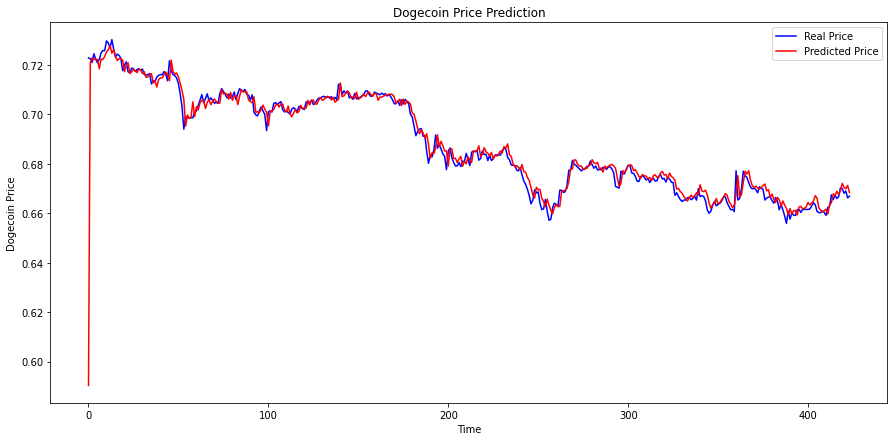

In [ ]:
rmse = np.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))

print(f"RMSE = {rmse}")

plt.figure(figsize= (15,7))
plt.plot(real_stock_price, color = 'blue', label = "Real Price")
plt.plot(predicted_stock_price, color = 'red', label = "Predicted Price")
plt.title("Dogecoin Price Prediction")
plt.xlabel("Time")
plt.ylabel("Dogecoin Price")
plt.legend()

plt.show()

# Notes on different model performances

In [ ]:
eval_dict = {"optimizer": ["adam","adam","adam","adam","adam","adam","adam","adam","adam", "adam", "rmsprop", "rmsprop", "adam"],
             "loss": ["mse","mse","mse","mse","mse","mse","mse","mse","mse", "mse", "mse", "mse", "mse"],
              "history_size": [14, 14, 3, 3, 2, 1, 2, 2, 2, 2, 2, 2, 2],
             "epochs": [500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500],
             "layer0": [50,50,50,50,50,50, 50, 50, 50, 50, 50, 100, 100],
            "layer1": [10, 20, 20, 20, 50, 50, 0, 50, 20, 20, 50, 10, 10],
           "layer2": [10, 10, 10, 20, 10, 10, 0, 50, 0, 10, 10, 0, 0],
           "layer3": [0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0],
           "layer4": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
           "layer5": [0, 0, 0, 0, 0, 0,0, 0, 0, 0, 0, 0, 0],
            "output": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
             "batch_size": [32,32,32,32,32,32,32,32,32,32,32,32,32],
           "rmse": [0.051, 0.037, 0.017, 0.018, 0.014, 0.021, 0.020, 0.023, np.NaN, 0.023, np.NaN, 0.020, 0.022]}

eval_df = pd.DataFrame.from_dict(eval_dict)

#for k,v in eval_dict.items():
  #print(f"{k} : {len(v)}")

eval_df

,optimizer,loss,history_size,epochs,layer0,layer1,layer2,layer3,layer4,layer5,output,batch_size,rmse
0,adam,mse,14,500,50,10,10,0,0,0,1,32,0.051
1,adam,mse,14,500,50,20,10,0,0,0,1,32,0.037
2,adam,mse,3,500,50,20,10,0,0,0,1,32,0.017
3,adam,mse,3,500,50,20,20,10,0,0,1,32,0.018
4,adam,mse,2,500,50,50,10,0,0,0,1,32,0.014
5,adam,mse,1,500,50,50,10,0,0,0,1,32,0.021
6,adam,mse,2,500,50,0,0,0,0,0,1,32,0.020
7,adam,mse,2,500,50,50,50,0,0,0,1,32,0.023
8,adam,mse,2,500,50,20,0,0,0,0,1,32,NaN
9,adam,mse,2,500,50,20,10,0,0,0,1,32,0.023


In [ ]:
df_final.head()

,price,Google_Trends
2021-08-28 00:00:00,-1.390250,-1.0
2021-08-28 01:00:00,-1.373264,-1.0
2021-08-28 02:00:00,-1.384719,-1.0
2021-08-28 03:00:00,-1.394196,-1.0
2021-08-28 04:00:00,-1.396323,-1.0


In [ ]:
df_pred = pd.DataFrame(X_test[0], columns= ["high", "Google_trends"])
df_pred

,high,Google_trends
0,0.623125,0.722772
1,0.640528,0.693069
2,0.651518,0.623762
3,0.647062,0.574257
4,0.648080,1.000000
5,0.750242,0.841584
6,0.772567,0.841584
7,0.733399,0.663366
8,0.718805,0.683168
9,0.714355,0.673267


In [ ]:
def preprocess(df, scaler):
    """method that pre-process the data"""

    # log transforming the data
    df["high"] = np.log(df["high"])

    # selecting relevant column from df
    dataset = df.values

    # scaling the data
    dataset_scaled = scaler.fit_transform(dataset)

    dataset_scaled = dataset_scaled.reshape(1,dataset.shape[0],dataset.shape[1])

    return dataset_scaled, scaler


def inverse_scaler(pred, scaler):

  pred = inverse_transformer(pred)

  pred = np.exp(pred)

  return pred

In [ ]:
df_pred_preproc, scaler = preprocess(df_pred, scaler)

In [ ]:
pred = model.predict(df_pred_preproc)
prediction = inverse_scaler(pred, scaler)[0][0]

prediction

IndexError: ignored

In [ ]:
df_pred_preproc.shape

In [ ]:
pred = model.predict(df_pred_preproc)[0][0]
pred

# Features

- historical price data
- google price data
- rendite (calculate daily return)
- kumulierte rendite (z.b. letzte 5 Tage)
- short term moving average (letzte 10 Tage)
- long term moving average (letzte 30 Tage)
- alternativ: binäres feature (liegt kurzfristiger MA über langfristigen MA)
- talib (financial indicators inkludieren)
- talib RSI (relative strength index)
- volumen inkludieren

- evtl. auf Klassifikationsproblem umsteigen